# Sentence encoders: Optimum test-size

This notebook examines the optimum test size when using tensorflow sentence encoders on a [Kaggle essay scores](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) dataset of ~17,000 texts. Varying the test size (0.1-0.7) shows us that on this small dataset, sentence enocoder models need all the data they can get.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Preprocess text

Common preprocessing steps are applied to simplify the texts and reduce potential noise.

In [2]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)

    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lowercase the text
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

## Functions

Tensorflow universal sentence encoder 4 is first loaded-in. A number of functions are then defined to split the essay texts in into the first x number of words, obtain the embeddings, fit a model and then record the time and accuracy results.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding
from sklearn.metrics import cohen_kappa_score

# downloads the model to obtain embeddings 
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_model = hub.load(model_url)

# returns the essay embeddings
def encode_sentences(essays):
    embeddings = encoder_model(essays)
    return embeddings.numpy()

# creates the model
def create_model(embedding_dim):
    model = Sequential([
          Input(shape=(embedding_dim,)),
          Dense(64, activation='relu'),
          Dense(32, activation='relu'),
          Dense(7, activation='softmax')
      ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# fits the model on the training data
def fit_model(embeddings, scores, test_size):

    # splits the data into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(embeddings, scores, test_size=test_size)

    # creates and embedding dim and then creates the model with it
    embedding_dim = embeddings[0].shape[0]
    model = create_model(embedding_dim)

    # converts essay score to one hot encodings
    y_train_one_hot = to_categorical(y_train)
    y_val_one_hot = to_categorical(y_val)

    # fits the model
    model.fit(x_train, y_train_one_hot, epochs=12, batch_size=32, validation_data=(x_val, y_val_one_hot)) 
    
    return model, x_val, y_val_one_hot

# returns the cohen kappa score for the validation set
def evaluate_model(model, x_val, y_val_one_hot, accuracy_df, test_size):
    predictions = model.predict(x_val)
    converted_preds = [np.argmax(pred) for pred in predictions]
    converted_y_val = [np.argmax(y) for y in y_val_one_hot]
    accuracy = round(cohen_kappa_score(converted_preds, converted_y_val, weights='quadratic'), 2)
    accuracy_df.loc[0, str(test_size)] = accuracy
    return accuracy_df

## Get embeddings

Here the embeddings are obtained and models fitted as part of a loop depending on the number of essay_length values given. 

In [4]:
# preprocesses the texts
train['full_text'] = [preprocess_text(x) for x in train['full_text']]

# converts scores to a numpy array for use in the model
scores = np.array(train['score'])

# creates a new dataframe to store accuracy results
accuracy_df = pd.DataFrame()

# limits each essay to the first 300 words
texts = [' '.join(x.split()[0:300]) for x in train['full_text']]

# retrieves the embeddings for each essay
embeddings = encode_sentences(texts)

# loops through each test size value, fitting a model, evaluating accuracy and appending the result to the accuracy_df
test_sizes = [0.1, 0.3, 0.5, 0.6, 0.7]
for test_size in test_sizes:
    model, x_val, y_val_one_hot = fit_model(embeddings, scores, test_size)
    evaluate_model(model, x_val, y_val_one_hot, accuracy_df, test_size)

Epoch 1/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4313 - loss: 1.4023 - val_accuracy: 0.5361 - val_loss: 1.0759
Epoch 2/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5369 - loss: 1.0620 - val_accuracy: 0.5673 - val_loss: 0.9954
Epoch 3/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5611 - loss: 1.0036 - val_accuracy: 0.5835 - val_loss: 0.9662
Epoch 4/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5722 - loss: 0.9663 - val_accuracy: 0.5875 - val_loss: 0.9427
Epoch 5/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5844 - loss: 0.9494 - val_accuracy: 0.5789 - val_loss: 0.9315
Epoch 6/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5896 - loss: 0.9316 - val_accuracy: 0.5869 - val_loss: 0.9304
Epoch 7/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5899 - loss: 0.9254 - val_accuracy: 0.5858 - val_loss: 0.9219
Epoch 8/12
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6056 - loss: 0.8990 - val_accuracy: 0.

## Visualization

The time and accuracy results are visualized as lineplots. We can see that both begin to plateau after the first ~250 words of each essay. 

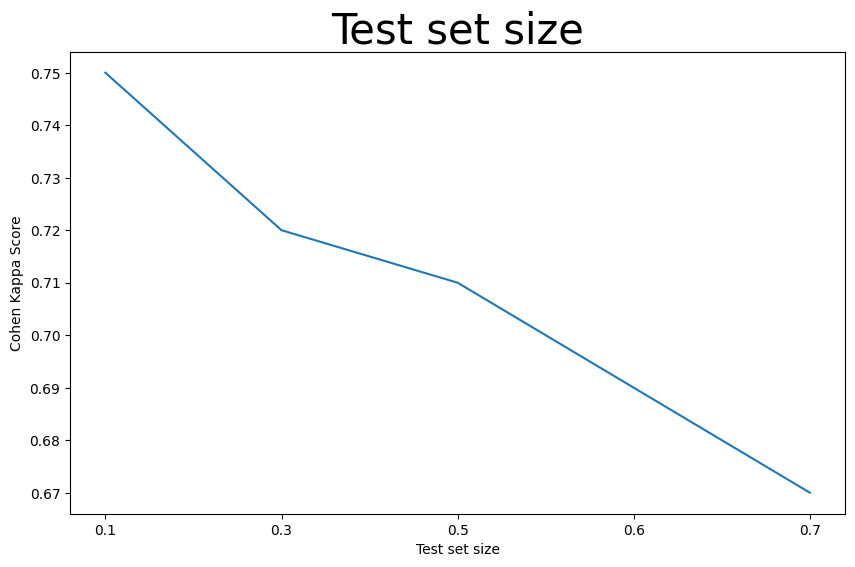

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# transposes the dataframe to get it in the right shape for plotting
accuracy_df = accuracy_df.transpose()

# plots the results as a lineplot in searborn
fig = plt.figure(figsize=(10, 6));
sns.lineplot(x=accuracy_df.index, y=accuracy_df.iloc[:,0], data=accuracy_df);
plt.title('Test set size', size=30);
plt.ylabel('Cohen Kappa Score');
plt.xlabel('Test set size');